In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levy_stable, norm
from code.finmath1 import BlackScholes
from code.stable_distribution.sampling import compute_first_crossing

In [3]:
def simulate_brownian(S0, mu, sigma, T, n_steps):
    """
    Геометрическое броуновское движение:
    S[i+1] = S[i] * exp((mu - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) * Z[i])
    Z ~ N(0,1)
    """

    dt = T / n_steps
    times = np.linspace(0.0, T, n_steps + 1)
    S = np.empty(n_steps + 1, dtype=float)
    S[0] = S0

    Z = norm.rvs(size=n_steps)

    for i in range(n_steps):
        S[i + 1] = S[i] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[i])

    return times, S

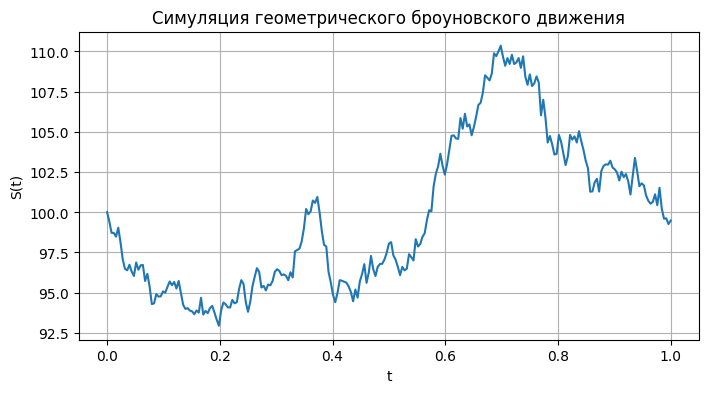

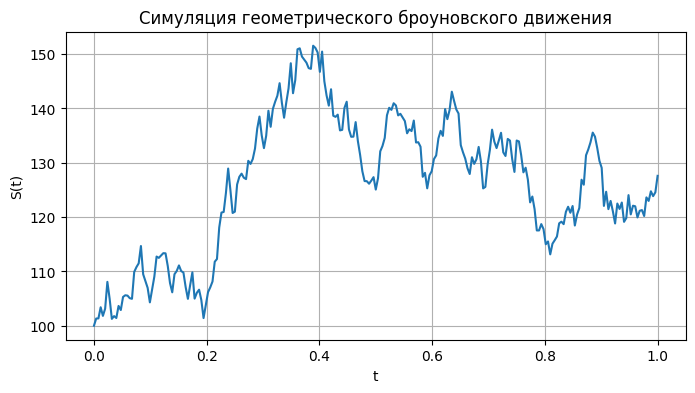

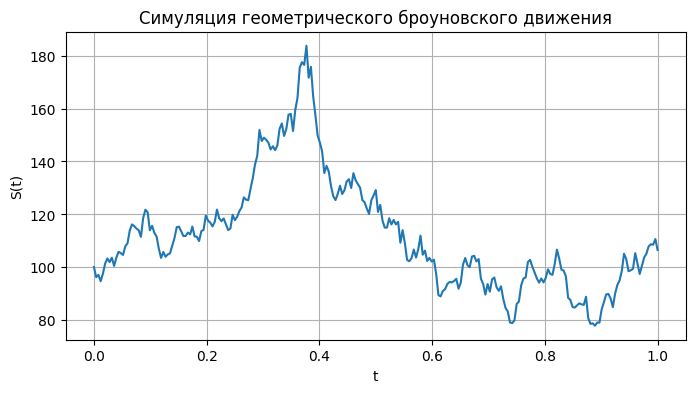

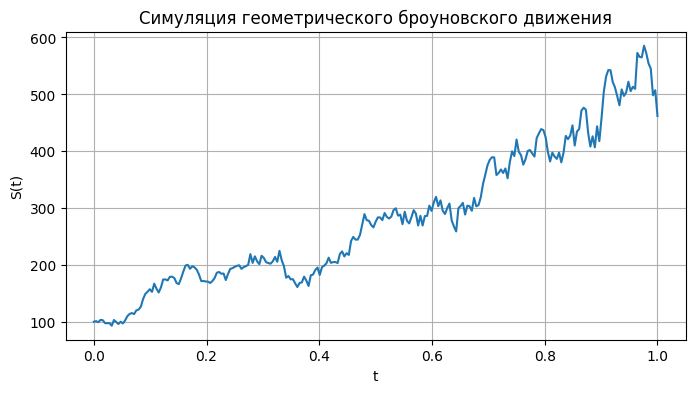

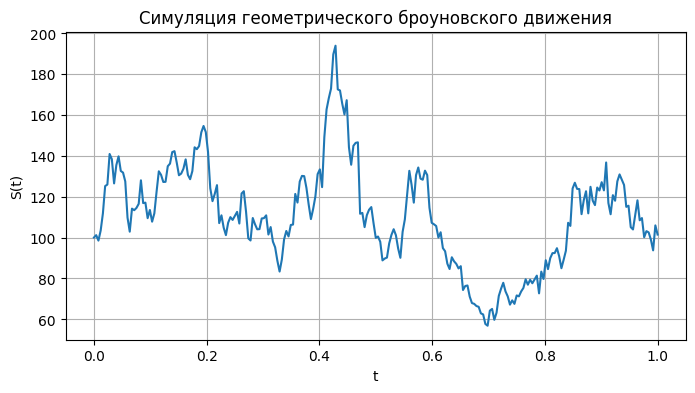

In [4]:
X0 = 100.0
mu = 0.1
T = 1.0
n_steps = 252

for sigma in np.linspace(0.1, 1.0, 5):
    times, S = simulate_brownian(X0, mu, sigma, T, n_steps)

    plt.figure(figsize=(8, 4))
    plt.plot(times, S)
    plt.xlabel("t")
    plt.ylabel("S(t)")
    plt.title("Cимуляция геометрического броуновского движения")
    plt.grid(True)
    plt.show()

In [5]:
# def sample_s_distr1(alpha: float = 0.5, gamma: float = 1, num_generations: int = 1):
#     pi = np.pi
#     U = np.random.uniform(-pi / 2, pi / 2, size=num_generations)
#     W = np.random.exponential(1, size=num_generations)
# 
#     U_0 = -1 / 2 * pi * (1 - abs(1 - alpha)) / alpha
#     term1 = np.sin(alpha * (U - U_0)) / np.power(np.cos(U), 1 / alpha)
#     term2 = np.power(np.cos(U - alpha * (U - U_0)) / W, (1 - alpha) / alpha)
# 
#     values = term1 * term2 * gamma
# 
#     return values


# def sample_s_distr(alpha: float = 1.0,
#                    beta: float = 1.0,
#                    c: float = 1.0,
#                    mu: float = 0.0,
#                    num_generations: int = 1
#                    ):
#     U = np.random.uniform(-np.pi / 2, np.pi / 2, size=num_generations)
#     W = np.random.exponential(scale=1.0, size=num_generations)
# 
#     zeta = -beta * np.tan(np.pi * alpha / 2)
#     if alpha != 1.0:
#         xi = (1.0 / alpha) * np.arctan(-zeta)
#     else:
#         xi = np.pi / 2
# 
#     if alpha != 1.0:
#         factor = (1 + zeta ** 2) ** (1 / (2 * alpha))
#         num = np.sin(alpha * (U + xi))
#         den = (np.cos(U)) ** (1 / alpha)
#         frac = num / den
#         inner = np.cos(U - alpha * (U + xi)) / W
#         X = factor * frac * inner ** ((1 - alpha) / alpha)
#     else:
#         term1 = (np.pi / 2 + beta * U) * np.tan(U)
#         term2 = beta * np.log(((np.pi / 2) * W * np.cos(U)) / (np.pi / 2 + beta * U))
#         X = (1 / zeta) * (term1 - term2)
# 
#     if c != 1.0:
#         if alpha != 1.0:
#             return c * X + mu
#         else:
#             return c * X + (2 / np.pi) + beta * c * np.log(c) + mu
# 
#     return X
# 
# 
# def sample_tau(alpha: float, T: float, t: float, n_paths: int = 1):
#     delta = T - t
#     S = sample_s_distr(alpha, num_generations=n_paths)
#     tau = (delta / S) ** alpha
#     return tau


# def sample_tau(alpha: float, T: float, t: float, n_paths: int = 1):
#     if not (0 < alpha <= 1):
#         raise ValueError("alpha must be in (0, 1].")
# 
#     if np.isclose(alpha, 1.0):
#         return np.full(n_paths, T - t)
# 
#     S = levy_stable.rvs(alpha=alpha, beta=1, loc=0.0, scale=1.0, size=n_paths)
# 
#     delta = np.power(T, alpha) - np.power(t, alpha)
#     tau = np.power(delta / S, alpha)
#     return tau


# def sample_positive_stable(alpha: float, beta: float=1.0,
#                            size: int = 1) -> np.ndarray:
#     """
#     Генерация положительного alpha-стабильного распределения
#     (beta=1 даёт одностороннюю «левостороннюю» стабильную левой шкалы).
#     """
#     # Используем встроенный генератор scipy
#     return levy_stable.rvs(alpha, beta, loc=0, scale=1.0, size=size)
# 
# def sample_tau(alpha: float, T: float, t: float, n_paths: int = 1) -> np.ndarray:
#     """
#     Сэмплирует E_{T-t} = inf{u: D(u)>T-t} по формуле:
#       E = ((T - t) / S)^(1/alpha),
#     где S ~ положительное alpha-стабильное( scale=1 ).
#     """
#     delta = T - t
#     # Для alpha близких к 1 можно вернуть детерминированный результат
#     # if np.isclose(alpha, 1.0):
#     #     return np.full(n_paths, delta)
#     # Сэмплируем S ~ S_alpha
#     S = sample_positive_stable(alpha, beta=1.0, size=n_paths)
#     # Преобразование в обратный субординатор
#     tau = (delta / S) ** (alpha)
#     return tau

In [6]:
def monte_carlo_vanilla(alpha: float,
                        T: float,
                        t: float,
                        S0: float,
                        K: float,
                        mu: float,
                        sigma: float,
                        r: float,
                        payoff: str = 'call',
                        n_paths: int = 1
                        ):
    
    tau = [compute_first_crossing(alpha=alpha, dtau=1e-2, T=T) for _ in range(n_paths)]
    # tau = compute_first_crossing(alpha=alpha, dtau=1e-2, T=T)
    tau = np.array(tau)
    Z = np.random.randn(n_paths)
    S_tau = S0 * np.exp((mu - 0.5 * sigma ** 2) * tau + sigma * np.sqrt(tau) * Z)

    if payoff == "call":
        payoff_vec = np.maximum(S_tau - K, 0.0) * np.exp(-r * (T - t))
    elif payoff == "put":
        payoff_vec = np.maximum(K - S_tau, 0.0) * np.exp(-r * (T - t))
    else:
        raise ValueError("payoff must be 'call' or 'put'")

    return payoff_vec.mean()

In [24]:
alpha = 1.0
T = 1
S0 = 100.0
K = 100.0
sigma = 0.2
r = 0.00
n_paths = int(1e5 / 2)
t = 0.0

# print(sample_tau(alpha=1.0, T=1.0, t=0.0, n_paths=100).mean())
print('Monte Carlo Vanilla (alpha = 1): CALL')
print(monte_carlo_vanilla(alpha=alpha, T=T, t=t, S0=S0, K=K, sigma=sigma, mu=r, r=r, payoff='call', n_paths=n_paths))
print('Monte Carlo Vanilla (alpha = 1): PUT')
print(monte_carlo_vanilla(alpha=alpha, T=T, t=t, S0=S0, K=K, sigma=sigma, mu=r, r=r, payoff='put', n_paths=n_paths))
print()

model = BlackScholes(sigma=sigma, r=r)
print('Black Scholes: CALL')
print(model.call_price(S0, T - t, K))
print('Black Scholes: PUT')
print(model.put_price(S0, T - t, K))

Monte Carlo Vanilla (alpha = 1): CALL
7.903059407998501
Monte Carlo Vanilla (alpha = 1): PUT
7.998560093178612

Black Scholes: CALL
7.965567455405804
Black Scholes: PUT
7.965567455405804


In [ ]:
for alpha in np.linspace(0.01, 1, 20):
    T = 1
    S0 = 100.0
    K = 100.0
    sigma = 0.2
    r = 0.00
    n_paths = 1000_000
    t = 0.0

    # print(sample_tau(alpha=1, T=1.0, t=0.5, n_paths=100).mean())
    print(f'Monte Carlo Vanilla (alpha = {alpha}): CALL')
    print(
        monte_carlo_vanilla(alpha=alpha, T=T, t=t, S0=S0, K=K, sigma=sigma, mu=r, r=r, payoff='call', n_paths=n_paths))
    print(f'Monte Carlo Vanilla (alpha = {alpha}): PUT')
    print(monte_carlo_vanilla(alpha=alpha, T=T, t=t, S0=S0, K=K, sigma=sigma, mu=r, r=r, payoff='put', n_paths=n_paths))

Monte Carlo Vanilla (alpha = 0.2): CALL
5.60025692260253
Monte Carlo Vanilla (alpha = 0.2): PUT
36.03235614110432
Monte Carlo Vanilla (alpha = 0.2877777777777778): CALL
9.794693120954292
Monte Carlo Vanilla (alpha = 0.2877777777777778): PUT
31.967217509077237
Monte Carlo Vanilla (alpha = 0.3755555555555556): CALL
15.189529643713046
Monte Carlo Vanilla (alpha = 0.3755555555555556): PUT
25.565972255458174
Monte Carlo Vanilla (alpha = 0.4633333333333334): CALL
17.068465210019124
Monte Carlo Vanilla (alpha = 0.4633333333333334): PUT
17.61067434391936
Monte Carlo Vanilla (alpha = 0.5511111111111111): CALL
11.969278678184777
Monte Carlo Vanilla (alpha = 0.5511111111111111): PUT
11.915534281369615
Monte Carlo Vanilla (alpha = 0.638888888888889): CALL
9.556806716789987
Monte Carlo Vanilla (alpha = 0.638888888888889): PUT
9.564356453611596
Monte Carlo Vanilla (alpha = 0.7266666666666668): CALL
8.581794420484494
Monte Carlo Vanilla (alpha = 0.7266666666666668): PUT
8.5824644840281
Monte Carlo Vanilla (alpha = 0.8144444444444445): CALL
8.192850940533866
Monte Carlo Vanilla (alpha = 0.8144444444444445): PUT
8.177100624290155
Monte Carlo Vanilla (alpha = 0.9022222222222223): CALL
8.036525290098975
Monte Carlo Vanilla (alpha = 0.9022222222222223): PUT
8.022802183067476
Monte Carlo Vanilla (alpha = 0.99): CALL
8.001861713100565
Monte Carlo Vanilla (alpha = 0.99): PUT
7.977717715754091
